In [1]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import cv2
import os, io, base64, json
from io import BytesIO
import time
import math
import onnxruntime
import matplotlib.pyplot as plt

In [2]:
class_names = ['direct', 'alternative']

# Create a list of colors for each class where each color is a tuple of 3 integer values
colors = [(65, 204, 123), (98, 137, 217)]


def nms(boxes, scores, iou_threshold):
    print("nms function from utils has been called")
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes


def compute_iou(box, boxes):
    print("compute_iou function from utils has been called")
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou


def xywh2xyxy(x):
    print("xywh2xyxy function from utils has been called")
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def sigmoid(x):
    print("sigmoid function from utils has been called")
    return 1 / (1 + np.exp(-x))


def draw_detections2(image, boxes, scores, class_ids, mask_alpha=0.3, mask_maps=None):
    print("draw_detections function from utils has been called")
    img_height, img_width = image.shape[:2]
    size = min([img_height, img_width]) * 0.0006
    text_thickness = int(min([img_height, img_width]) * 0.001)

    mask_img = draw_masks2(image, boxes, class_ids, mask_alpha, mask_maps)

    # Draw bounding boxes and labels of detections
    for box, score, class_id in zip(boxes, scores, class_ids):
        color = colors[class_id]

        x1, y1, x2, y2 = box.astype(int)

        # Draw rectangle
        cv2.rectangle(mask_img, (x1, y1), (x2, y2), color, 2)

        label = class_names[class_id]
        caption = f'{label} {int(score * 100)}%'
        (tw, th), _ = cv2.getTextSize(text=caption, fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                      fontScale=size, thickness=text_thickness)
        th = int(th * 1.2)

        cv2.rectangle(mask_img, (x1, y1),
                      (x1 + tw, y1 - th), color, -1)

        cv2.putText(mask_img, caption, (x1, y1),
                    cv2.FONT_HERSHEY_SIMPLEX, size, (255, 255, 255), text_thickness, cv2.LINE_AA)

    return mask_img


def draw_masks2(image, boxes, class_ids, mask_alpha=0.3, mask_maps=None):
    print("draw_masks function from utils has been called")
    mask_img = image.copy()

    # Draw bounding boxes and labels of detections
    for i, (box, class_id) in enumerate(zip(boxes, class_ids)):
        color = colors[class_id]

        x1, y1, x2, y2 = box.astype(int)

        # Draw fill mask image
        if mask_maps is None:
            cv2.rectangle(mask_img, (x1, y1), (x2, y2), color, -1)
        else:
            crop_mask = mask_maps[i][y1:y2, x1:x2, np.newaxis]
            crop_mask_img = mask_img[y1:y2, x1:x2]
            crop_mask_img = crop_mask_img * (1 - crop_mask) + crop_mask * color
            mask_img[y1:y2, x1:x2] = crop_mask_img

    return cv2.addWeighted(mask_img, mask_alpha, image, 1 - mask_alpha, 0)

In [3]:
def initialize_model(path, conf_thres=0.7, iou_thres=0.5, num_masks=32):
    print("initialize_model function from the class has been called")
    session = onnxruntime.InferenceSession(path,
                                            providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    input_names, input_shape, input_height, input_width = get_input_details(session)
    output_names = get_output_details(session)
    return session, input_names, input_shape, input_height, input_width, output_names, conf_thres, iou_thres, num_masks

def segment_objects(session, input_names, output_names, conf_threshold, iou_threshold, num_masks, image, img_height, img_width, input_height, input_width):
    print("segment_objects function from the class has been called")
    input_tensor = prepare_input(image, input_height, input_width)

    outputs = inference(session, input_names, output_names, input_tensor)

    boxes, scores, class_ids, mask_pred = process_box_output(outputs[0], conf_threshold, iou_threshold, num_masks, img_height, img_width, input_height, input_width)
    mask_maps = process_mask_output(mask_pred, outputs[1], boxes, img_height, img_width)
    return boxes, scores, class_ids, mask_maps

def prepare_input(image, input_height, input_width):
    print("prepare_input function from the class has been called")
    img_height, img_width, _ = image.shape
    input_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_img = cv2.resize(input_img, (input_width, input_height))
    input_img = input_img / 255.0
    input_img = input_img.transpose(2, 0, 1)
    input_tensor = input_img[np.newaxis, :, :, :].astype(np.float32)
    return input_tensor

def inference(session, input_names, output_names, input_tensor):
    print("inference function from the class has been called")
    start = time.perf_counter()
    outputs = session.run(output_names, {input_names[0]: input_tensor})
    print(f"Inference time: {(time.perf_counter() - start)*1000:.2f} ms")
    return outputs

def process_box_output(box_output, conf_threshold, iou_threshold, num_masks, img_height, img_width, input_height, input_width):
    print("process_box_output function from the class has been called")
    predictions = np.squeeze(box_output).T
    num_classes = box_output.shape[1] - num_masks - 4

    scores = np.max(predictions[:, 4:4+num_classes], axis=1)
    predictions = predictions[scores > conf_threshold, :]
    scores = scores[scores > conf_threshold]

    if len(scores) == 0:
        return [], [], [], np.array([])

    box_predictions = predictions[..., :num_classes+4]
    mask_predictions = predictions[..., num_classes+4:]

    class_ids = np.argmax(box_predictions[:, 4:], axis=1)

    boxes = extract_boxes(box_predictions, img_height, img_width, input_height, input_width)

    indices = nms(boxes, scores, iou_threshold)

    return boxes[indices], scores[indices], class_ids[indices], mask_predictions[indices]

def process_mask_output(mask_predictions, mask_output ,boxes, img_height, img_width):
    print("process_mask_output function from the class has been called")
    if mask_predictions.shape[0] == 0:
        return []

    mask_output = np.squeeze(mask_output)

    # Calculate the mask maps for each box
    num_mask, mask_height, mask_width = mask_output.shape  # CHW
    masks = sigmoid(mask_predictions @ mask_output.reshape((num_mask, -1)))
    masks = masks.reshape((-1, mask_height, mask_width))

    # Downscale the boxes to match the mask size
    scale_boxes = rescale_boxes(boxes,
                                (img_height, img_width),
                                (mask_height, mask_width))

    # For every box/mask pair, get the mask map
    mask_maps = np.zeros((len(scale_boxes), img_height, img_width))
    blur_size = (int(img_width / mask_width), int(img_height / mask_height))
    for i in range(len(scale_boxes)):

        scale_x1 = int(math.floor(scale_boxes[i][0]))
        scale_y1 = int(math.floor(scale_boxes[i][1]))
        scale_x2 = int(math.ceil(scale_boxes[i][2]))
        scale_y2 = int(math.ceil(scale_boxes[i][3]))

        x1 = int(math.floor(boxes[i][0]))
        y1 = int(math.floor(boxes[i][1]))
        x2 = int(math.ceil(boxes[i][2]))
        y2 = int(math.ceil(boxes[i][3]))

        scale_crop_mask = masks[i][scale_y1:scale_y2, scale_x1:scale_x2]
        crop_mask = cv2.resize(scale_crop_mask,
                            (x2 - x1, y2 - y1),
                            interpolation=cv2.INTER_CUBIC)

        crop_mask = cv2.blur(crop_mask, blur_size)

        crop_mask = (crop_mask > 0.5).astype(np.uint8)
        mask_maps[i, y1:y2, x1:x2] = crop_mask

    return mask_maps

def extract_boxes(box_predictions, img_height, img_width, input_height, input_width):
    print("extract_boxes function from the class has been called")
    boxes = box_predictions[:, :4]
    boxes = rescale_boxes(boxes, (input_height, input_width), (img_height, img_width))
    boxes = xywh2xyxy(boxes)
    boxes[:, 0] = np.clip(boxes[:, 0], 0, img_width)
    boxes[:, 1] = np.clip(boxes[:, 1], 0, img_height)
    boxes[:, 2] = np.clip(boxes[:, 2], 0, img_width)
    boxes[:, 3] = np.clip(boxes[:, 3], 0, img_height)
    return boxes

def rescale_boxes(boxes, input_shape, image_shape):
    print("rescale_boxes function from the class has been called")
    input_shape = np.array([input_shape[1], input_shape[0], input_shape[1], input_shape[0]])
    boxes = np.divide(boxes, input_shape, dtype=np.float32)
    boxes *= np.array([image_shape[1], image_shape[0], image_shape[1], image_shape[0]])
    return boxes

def draw_detections(image, boxes, scores, class_ids, mask_maps, mask_alpha=0.4):
    print("draw_detections function from the class has been called")
    return draw_detections2(image, boxes, scores, class_ids, mask_alpha)

def draw_masks(image, boxes, scores, class_ids, mask_maps, mask_alpha=0.5):
    print("draw_masks function from the class has been called")
    return draw_detections2(image, boxes, scores, class_ids, mask_alpha, mask_maps=mask_maps)

def get_input_details(session):
    print("get_input_details function from the class has been called")
    model_inputs = session.get_inputs()
    input_names = [model_inputs[i].name for i in range(len(model_inputs))]
    input_shape = model_inputs[0].shape
    input_height = input_shape[2]
    input_width = input_shape[3]
    return input_names, input_shape, input_height, input_width

def get_output_details(session):
    print("get_output_details function from the class has been called")
    model_outputs = session.get_outputs()
    output_names = [model_outputs[i].name for i in range(len(model_outputs))]
    return output_names


In [4]:
model_path = "model/best.onnx"
session, input_names, input_shape, input_height, input_width, output_names, conf_thres, iou_thres, num_masks = initialize_model(model_path, conf_thres=0.5, iou_thres=0.3)

initialize_model function from the class has been called


/Users/shady/anaconda3/envs/myenv/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


get_input_details function from the class has been called
get_output_details function from the class has been called


In [5]:
img_file_path = './data/d3f34243-a7166713.jpg'
img = cv2.imread(img_file_path)

In [6]:
boxes, scores, class_ids, masks = segment_objects(session, input_names, output_names, conf_thres, iou_thres, num_masks, img, img.shape[0], img.shape[1], input_height, input_width)

segment_objects function from the class has been called
prepare_input function from the class has been called
inference function from the class has been called
Inference time: 352.15 ms
process_box_output function from the class has been called
extract_boxes function from the class has been called
rescale_boxes function from the class has been called
xywh2xyxy function from utils has been called
nms function from utils has been called
compute_iou function from utils has been called
compute_iou function from utils has been called
process_mask_output function from the class has been called
sigmoid function from utils has been called
rescale_boxes function from the class has been called


In [7]:
output_mask = draw_masks(img, boxes, scores, class_ids, masks)

draw_masks function from the class has been called
draw_detections function from utils has been called
draw_masks function from utils has been called


In [23]:
# use PIL to change the image from bgr to rgb
from PIL import Image
rgb_img = Image.fromarray(output_mask[..., ::-1])

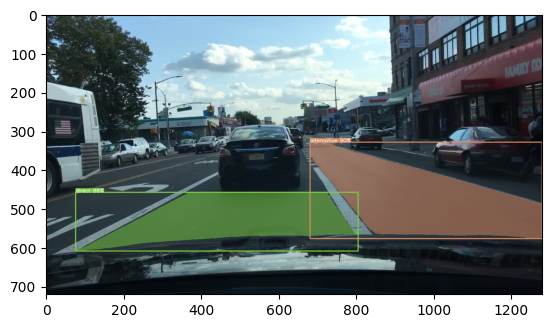

In [24]:
plt.imshow(rgb_img)

In [11]:
print(type(output_mask))

<class 'numpy.ndarray'>


In [12]:
_, np_array = cv2.imencode('.jpg', output_mask)
np_array.dtype

dtype('uint8')

In [13]:
image_bytes = np_array.tobytes()

In [14]:
response = {
    "image_data": image_bytes
}

In [15]:
response

{'image_data': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x02\xd0\x05\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x

In [16]:
len(response["image_data"])

175738

In [20]:
result_img = Image.open(io.BytesIO(response["image_data"]))

In [21]:
type(result_img)

PIL.JpegImagePlugin.JpegImageFile

In [18]:
type(reconstructed_array)

numpy.ndarray

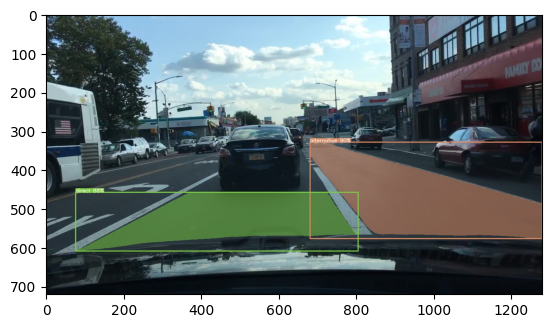

In [22]:
plt.imshow(result_img)

In [12]:
# Create a BytesIO object from the buffer
buffer = BytesIO(buffer)
# Convert BytesIO to base64-encoded string
image_data = base64.b64encode(buffer.getvalue()).decode('utf-8')

In [13]:
image_data

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD847H4jfFDxVqGNM8DW3/HpDcXn2T/AKZy/wCt/wDi69Q8D64Nc+zeOfhnqf8AZniG0u/tF3aXfl/ZLj915Ussckn+qk/uW9e0fDn/AIdn/FTULr/hZnhnxNpn+iQ3GkXf+pmuJo/+WUfl/J8/8cdeX33gf4f33g/+zNM/0q7

In [17]:
print(f"image_data size: {len(image_data)}")

image_data size: 234320
